<a href="https://colab.research.google.com/github/chavgova/predictNeuron_honor/blob/main/model_GRU_notnorm_2_5_noShuff_A06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import scipy.io
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential, model_from_json

Load Data

In [2]:
label_data_folder = "/content/drive/MyDrive/Single channels data/Marked spike vectors"
raw_data_folder = "/content/drive/MyDrive/Single channels data/28102021_03_01_nbasal_0001/data"

In [3]:
os.chdir(raw_data_folder)
mat_files = glob.glob("*.mat")

data_dict = {}

for file in mat_files[:20]:
    # Load the .mat file using scipy.io.loadmat
    mat = scipy.io.loadmat(file)
    data_dict[file[27:30]] = np.concatenate(mat['data'])

print(data_dict.keys())
raw_df = pd.DataFrame.from_dict(data_dict, orient='columns')
raw_df

dict_keys(['A02', 'A05', 'A03', 'B07', 'B06', 'B01', 'B03', 'A06', 'B02', 'B05', 'C06', 'C03', 'C02', 'C05', 'C04', 'C01', 'D01', 'C07', 'D03', 'D02'])


,A02,A05,A03,B07,B06,B01,B03,A06,B02,B05,C06,C03,C02,C05,C04,C01,D01,C07,D03,D02
0,-1.921908,-4.485947,2.472312,-1.004966,2.960513,1.983918,1.373807,-2.959032,0.274880,-0.762878,0.031140,3.020819,5.462379,-2.471503,-1.556942,0.885219,-0.762241,-1.067851,0.336652,-5.341440
1,-1.250521,-6.561143,1.007469,-3.202231,0.824282,3.326691,1.495877,0.886183,-0.030296,1.190247,0.580456,2.959784,4.119606,-2.898749,-0.641415,-1.312047,-3.569858,-0.152323,2.106672,-4.609018
2,0.397428,-4.546983,2.167137,-1.981528,-1.311948,3.814972,1.312772,0.519972,-1.861351,1.922668,1.251843,0.335272,1.617165,2.167169,-1.556942,-3.875523,-0.823276,-5.889628,-0.212664,-2.716929
3,-4.546420,-3.936631,4.242332,-4.911216,-0.884702,4.364289,-2.166232,1.557570,-1.983421,0.274719,-0.701282,-3.448907,0.457497,1.190607,2.532413,-4.852086,-8.208530,1.922872,0.214582,1.921743
4,-2.715365,-7.415635,4.181297,-2.103599,3.815005,1.068390,3.449002,-0.334520,0.702126,4.791321,-0.884388,2.532538,-1.190453,0.397150,-0.641415,1.800746,0.397427,0.458028,-0.212664,-1.130015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998995,0.153287,-1.006944,-2.532570,-0.821860,3.021548,3.143586,0.641385,-10.893602,1.983864,1.190247,-3.203724,-2.777521,-4.486351,-7.110175,2.715519,4.059047,0.397427,5.218770,-0.639910,1.799673
2998996,0.763639,-2.166612,-3.326027,5.281655,3.143618,1.922882,3.937284,-13.579149,4.547340,-2.349793,-2.410267,-3.387872,1.434059,-5.645331,0.029972,2.838344,-4.058139,5.829122,2.717023,3.020376
2998997,1.801236,-1.067979,-0.640481,0.765054,2.716372,-1.800262,-2.288302,-5.888719,-2.227562,-3.021179,-5.095814,-3.815118,-0.763207,-8.513983,-0.519344,-1.556187,-2.837436,2.716329,-5.034441,1.311392
2998998,5.097135,-9.979112,0.580223,0.398843,-0.884702,0.763215,-2.776583,2.534132,-0.701683,-2.471863,-5.645130,-0.763361,-1.068382,-9.673651,-6.867001,-3.997594,0.214322,7.171895,-1.189227,-2.533823


Absolute values of the raw data

In [4]:
#raw_df = raw_df.abs()

*   0 - no spike
*   1 - spike


example data

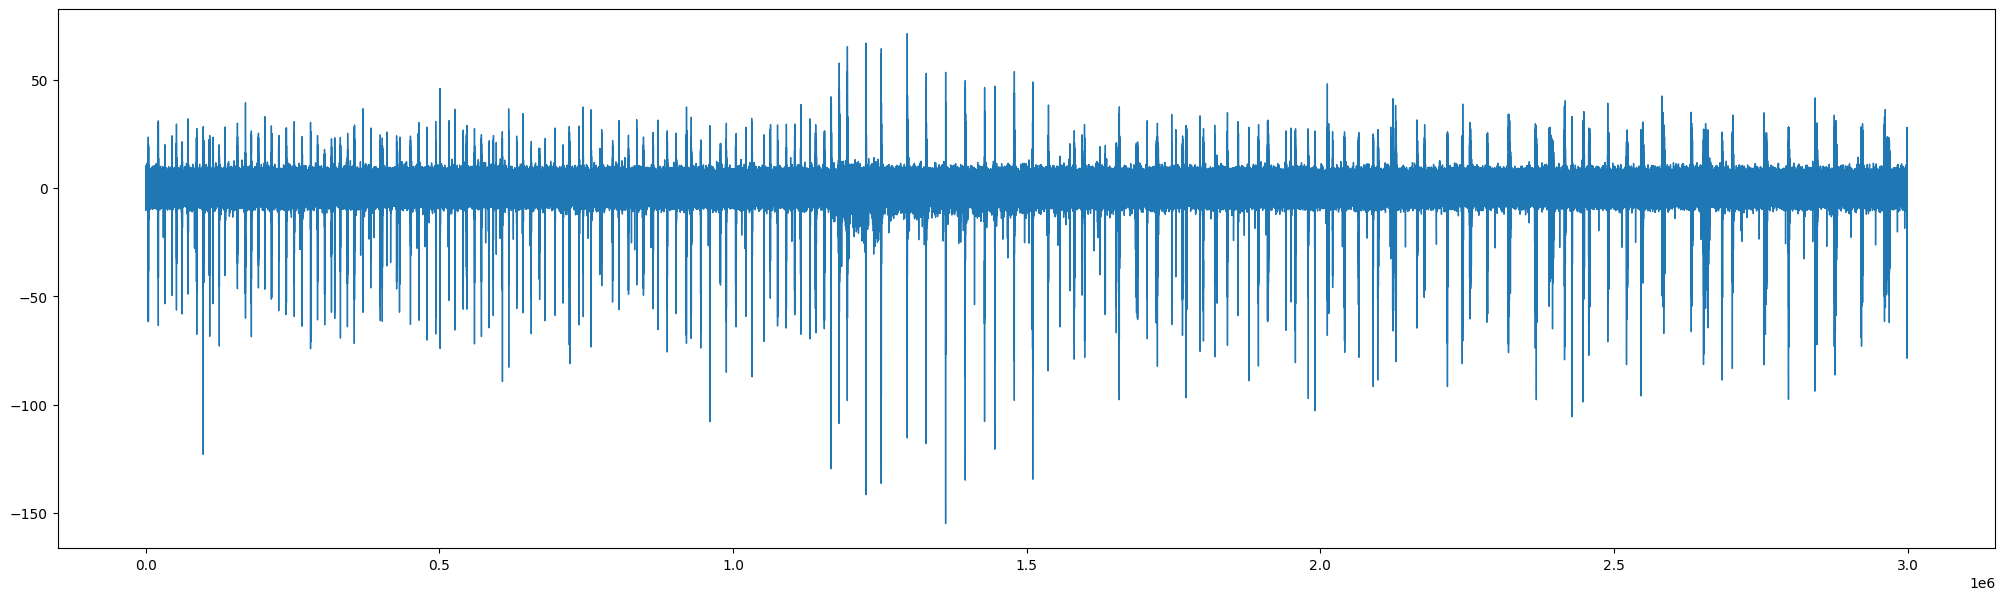

In [5]:
plt.figure(figsize=(25,7))
plt.plot(raw_df['A06'], linewidth = 1)
plt.show()

# Data Pre-Processing

variables

In [6]:
neurons = ['A06'] # neurons data

n_data_points = 2 # number of data points considered for training # V n=2, 1<t<10
t_data_points = 5 # number of FUTURE data points in which is predicted if there is a spike or no

In [7]:
raw_df = raw_df[neurons]

raw_data = raw_df.values.T

raw_data.shape

(1, 2999000)

Scaling

In [8]:
raw_data = raw_data[0][:-1]

In [9]:
# scaler = StandardScaler()
# raw_data = scaler.fit_transform(raw_data)

In [10]:
raw_data.shape[0]// n_data_points

1499499

Split RAW data; Input-Output

In [11]:
smaller_parts = []
samp = []

labels = []

num_parts = raw_data.shape[0] // n_data_points
for i in range(0, num_parts-1):
    raw_part = raw_data[i * n_data_points: (i + 1) * n_data_points]
    smaller_parts.append(raw_part)
    future = raw_data[(i + 1) * n_data_points : ((i + 1) * n_data_points + t_data_points)]
    labels.append(future)

labels = labels[:-1]
smaller_parts = smaller_parts[:-1]
# Convert the list of smaller parts to a NumPy array
raw_split_data = np.array(smaller_parts)
labels = np.array(labels)

raw_split_data.shape, labels.shape

((1499497, 2), (1499497, 5))

In [12]:
raw_split_data = np.reshape(raw_split_data, (raw_split_data.shape[0], 1, raw_split_data.shape[1]))

# Test-Train split
wirth the same ratio of 0s and 1s in test and train data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(raw_split_data, labels, test_size=0.2, shuffle=False)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1199597, 1, 2)
X_test shape: (299900, 1, 2)
y_train shape: (1199597, 5)
y_test shape: (299900, 5)


In [14]:
y_test[143]

array([ 1.0692885 , -5.40043807, -0.76176619, -1.61625838, -0.82280135])

# Model

In [15]:
model = Sequential()
model.add(GRU(n_data_points, input_shape=(1, n_data_points), return_sequences=True))  # Input layer
model.add(GRU(units=32, return_sequences=True))
model.add(GRU(units=16, return_sequences=False))
model.add(Dense(8, activation='tanh'))
model.add(Dense(t_data_points, activation='linear'))  # Output layer with 5 neurons and linear activation (binary classification)

# Specify class weights
class_weights = {0: 1, 1: 200}

model.compile(optimizer='adam', loss='mse')


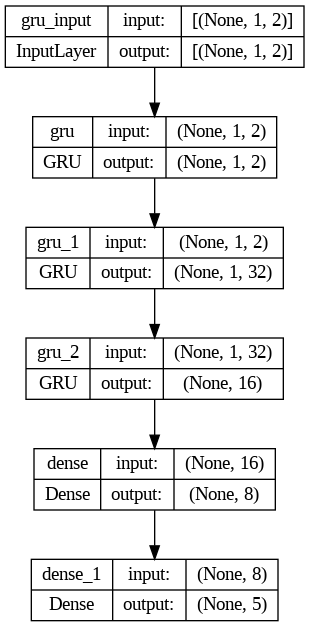

In [16]:
tf.keras.utils.plot_model(
    model,
    to_file="img_model.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

tf.keras.utils.plot_model(model, show_shapes=True)

class_weight=class_weights,

In [17]:
history_model = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
37488/37488 [==============================] - 212s 5ms/step - loss: 14.6480 - val_loss: 15.8539
Epoch 2/10
37488/37488 [==============================] - 206s 5ms/step - loss: 14.3119 - val_loss: 15.7780
Epoch 3/10
37488/37488 [==============================] - 210s 6ms/step - loss: 14.2728 - val_loss: 15.8071
Epoch 4/10
37488/37488 [==============================] - 208s 6ms/step - loss: 14.2476 - val_loss: 15.6711
Epoch 5/10
37488/37488 [==============================] - 202s 5ms/step - loss: 14.2297 - val_loss: 15.7377
Epoch 6/10
37488/37488 [==============================] - 202s 5ms/step - loss: 14.2260 - val_loss: 15.6216
Epoch 7/10
37488/37488 [==============================] - 202s 5ms/step - loss: 14.2183 - val_loss: 15.6631
Epoch 8/10
37488/37488 [==============================] - 202s 5ms/step - loss: 14.2172 - val_loss: 15.6783
Epoch 9/10
37488/37488 [==============================] - 203s 5ms/step - loss: 14.2127 - val_loss: 15.7095
Epoch 10/10
37488/37488 [===

In [18]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/models/model_GRU_notnorm_2_5_noShuff_A06.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/models/model_GRU_notnorm_2_5_noShuff_A06.h5")
print("Saved model to disk")

Saved model to disk


In [19]:
pred = model.predict(X_test)

9372/9372 [==============================] - 22s 2ms/step


In [20]:
pred.shape

(299900, 5)

In [21]:
pred

array([[ 1.5221200e+00,  1.2077684e+00,  1.0155040e+00,  8.9349234e-01,
         8.0736136e-01],
       [-8.1818104e-03,  3.6329031e-03, -1.3494253e-02, -6.0422421e-03,
        -1.7688394e-02],
       [ 5.8006001e-01,  4.7128296e-01,  3.9403617e-01,  3.5475075e-01,
         3.1531978e-01],
       ...,
       [ 2.4281921e+00,  1.9392109e+00,  1.6549727e+00,  1.4718405e+00,
         1.3560374e+00],
       [-8.0823269e+00, -5.9804296e+00, -4.5573831e+00, -3.5175056e+00,
        -2.8820210e+00],
       [-2.7942002e+00, -2.2040734e+00, -1.9244559e+00, -1.6820772e+00,
        -1.5416142e+00]], dtype=float32)

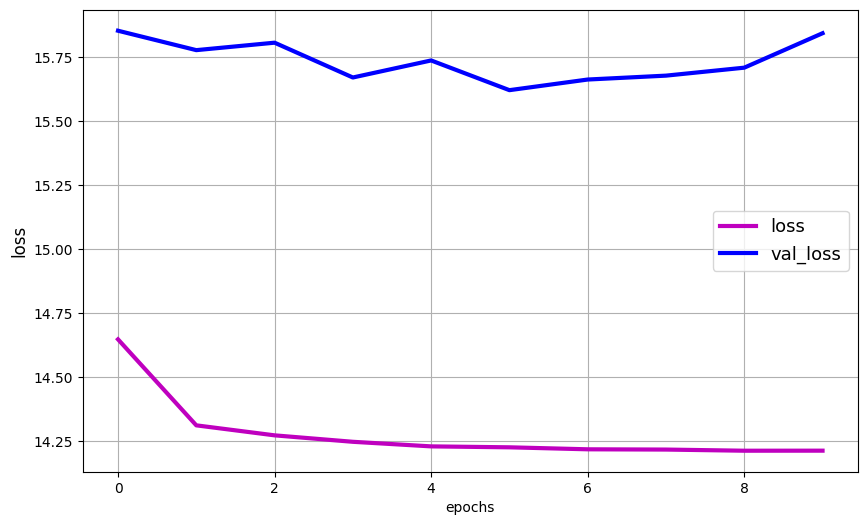

In [22]:
plt.figure(figsize=(10,6))
plt.plot(history_model.history['loss'], 'm', linewidth=3)
plt.plot(history_model.history['val_loss'], 'b', linewidth=3)
plt.legend(['loss', 'val_loss'], fontsize=13)
plt.xlabel('epochs')
plt.ylabel('loss', fontsize=12)
plt.grid(True)
plt.show()

In [23]:
pred.shape

(299900, 5)

In [24]:
mae = mean_absolute_error(y_test, pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 2.5974726811301294


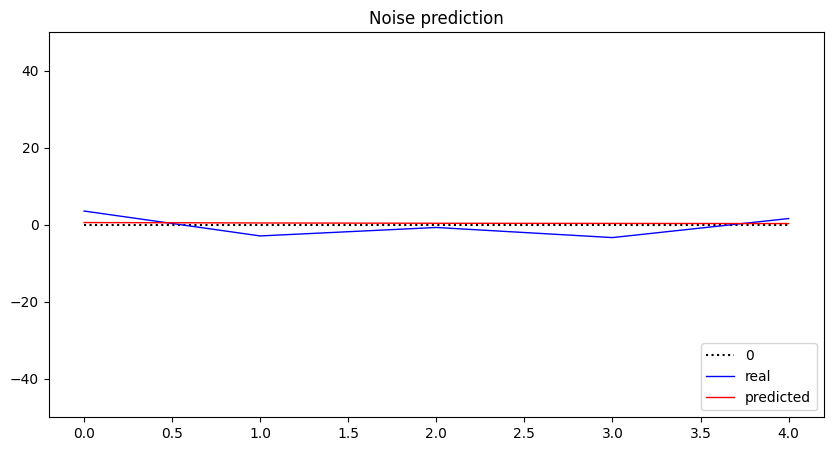

In [25]:
sample = 2

plt.figure(figsize=(10,5))
plt.hlines(y=0, color='black', xmin=0, xmax=4, linestyles='dotted')
plt.plot(y_test[sample], linewidth = 1, color='b')
plt.plot(pred[sample], linewidth = 1, color='r')
plt.ylim(-50, 50)
plt.legend(["0", "real", "predicted"], loc="lower right")
plt.title('Noise prediction')
plt.show()

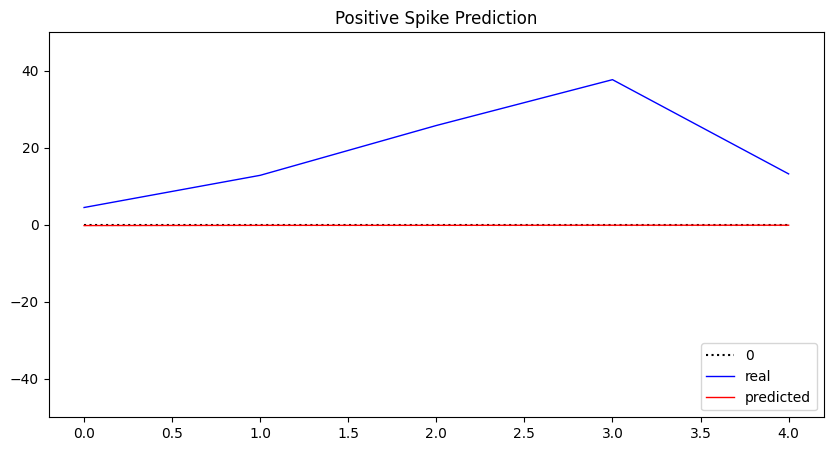

In [30]:
sample = 8105

plt.figure(figsize=(10,5))
plt.hlines(y=0, color='black', xmin=0, xmax=4, linestyles='dotted')
plt.plot(y_test[sample], linewidth = 1, color='b')
plt.plot(pred[sample], linewidth = 1, color='r')
plt.ylim(-50, 50)
plt.legend(["0", "real", "predicted"], loc="lower right")
plt.title('Positive Spike Prediction')
plt.show()

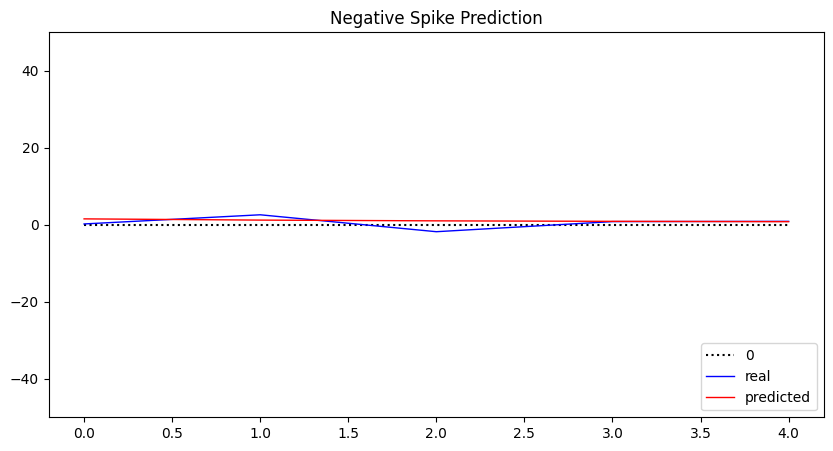

In [27]:
sample = 9875

plt.figure(figsize=(10,5))
plt.hlines(y=0, color='black', xmin=0, xmax=4, linestyles='dotted')
plt.plot(y_test[sample], linewidth = 1, color='b')
plt.plot(pred[sample], linewidth = 1, color='r')
plt.ylim(-50, 50)
plt.legend(["0", "real", "predicted"], loc="lower right")
plt.title('Negative Spike Prediction')
plt.show()

In [28]:
for a in range(0, 10000):
  if max(y_test[a]) > 20:
    print(a, '- - ', y_test[a])

8104 - -  [ 1.43549943 -1.49418807  4.48725725 12.84907365 25.78852678]
8105 - -  [ 4.48725725 12.84907365 25.78852678 37.69038225 13.21528459]
8106 - -  [25.78852678 37.69038225 13.21528459 -6.68217635 -7.719774  ]
8129 - -  [12.72700334 11.01801897  8.33247209 20.90571428 17.60981584]
8130 - -  [ 8.33247209 20.90571428 17.60981584  1.67964006  4.36518693]
8186 - -  [-5.03422713 12.23872209 14.7411635  18.76948381 23.95747209]
8187 - -  [14.7411635  18.76948381 23.95747209 27.0092299  22.1264174 ]
8188 - -  [ 23.95747209  27.0092299   22.1264174   -3.87455916 -11.01567244]
8189 - -  [ 22.1264174   -3.87455916 -11.01567244 -18.15678572 -17.18022322]
8208 - -  [-21.94096541 -27.98344588   3.38862443  24.20161272  20.1732924 ]
8209 - -  [ 3.38862443 24.20161272 20.1732924   8.75971818  6.68452287]
8210 - -  [ 20.1732924    8.75971818   6.68452287  -0.27348494 -14.92192244]
8263 - -  [-1.12797713 -0.39555525  5.70796037 14.80219865 21.02778459]
8264 - -  [ 5.70796037 14.80219865 21.027784